In [1]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks import UniversalPerturbation
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

from torchvision import datasets, transforms
import torch
import numpy as np
from torch.utils.data import SubsetRandomSampler

from matplotlib import pyplot as plt

import torchvision.models as models


In [2]:
np.random.seed(1337)
numberOfClasses = 2

class Net(nn.Module):
    def __init__(self, num_classes=numberOfClasses):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [3]:
# Setp 1a: define data transform
data_transform = transforms.Compose([
        #transforms.RandomRotation(30),
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])



# Step 1: Load the dataset
breakhis = datasets.ImageFolder(root ='C:\\Users\\Florian\\Desktop\\Datensätze_ready\\BreakHis_v1', 
                                 transform=data_transform)


# split into train and test dataset
train_split = 0.8
dataset_size = len(breakhis) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


#train set
dataset_loader_train = torch.utils.data.DataLoader(breakhis, sampler=SubsetRandomSampler(train_indices), batch_size=int(np.floor(train_split * dataset_size)))
dataiter = iter(dataset_loader_train)
images, labels = dataiter.next()
x_train = images.data.numpy()
y_train = np.zeros((len(labels.data.numpy()), len(breakhis.classes)))
y_train[np.arange(len(labels.data.numpy())), labels.data.numpy()] = 1

#test set
dataset_loader_test = torch.utils.data.DataLoader(breakhis, sampler=SubsetRandomSampler(test_indices), batch_size=(len(breakhis)-int(np.floor(train_split * dataset_size))))
dataiter = iter(dataset_loader_test)
images, labels = dataiter.next()
x_test = images.data.numpy()
y_test = np.zeros((len(labels.data.numpy()), len(breakhis.classes)))
y_test[np.arange(len(labels.data.numpy())), labels.data.numpy()] = 1


In [4]:
#x_train.shape
#numberOfClasses

In [5]:
# Step 2: Create the model
model = Net()

In [6]:
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [7]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=numberOfClasses)

In [8]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=10, nb_epochs=100)

In [9]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 81.69014084507043%


In [16]:
# Step 6: Generate adversarial test examples
#attack = FastGradientMethod(classifier=classifier, eps=0.2)

#delta = desired accuracy on perturbed samples
dictForAttacker ={
  "targeted": True
}
#try next: pgd
attack = UniversalPerturbation(classifier, attacker="pgd", attacker_params=dictForAttacker, delta=0.5, max_iter=100, eps=10.0)

x_test_adv = attack.generate(x=x_test, y=y_test)

KeyboardInterrupt: 

In [11]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))

Accuracy on adversarial test examples: 47.183098591549296%


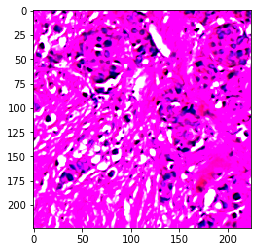

In [12]:
plt.imshow(x_test[1].transpose((1, 2, 0)))
plt.show()

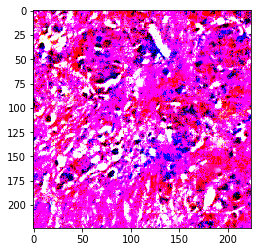

In [13]:
plt.imshow(x_test_adv[1].transpose((1, 2, 0)))


In [14]:
#engable log to console
import logging
import sys

logging.basicConfig(
    level=logging.DEBUG, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(filename='tmp5a.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

In [15]:
classifier

art.classifiers.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): Net(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5)